## End-to-End Object Detection with DETR

The goal of this tutorial is to fine-tune [DETR](https://ai.facebook.com/blog/end-to-end-object-detection-with-transformers) on a custom object detection dataset. The model's aim is to recognize wheat heads from outdoor images of wheat plants.

- Original DETR paper: https://arxiv.org/abs/2005.12872
- Original DETR repo: https://github.com/facebookresearch/detr


### Introduction
Object detection involves predicting a series of Bounding Box coordinates and labels. The majority of modern detectors perform this task indirectly by defining anchors, proposals, or windows, and constructing the problem as a classification/regression problem. In this paper, transformers are applied to the field of object detection, replacing the current model that requires manual design, with excellent results. 

DETR is comparable to Faster RCNN in terms of accuracy and running time on object detection; when applied to panoptic segmentation tasks, DETR even outperforms other baseline models. This is the first time that DETR has solved the detection problem using the End to End method. The solution is to treat the detection problem as a set prediction problem, as depicted in Figure 1.

<br>
<center><img src="https://media.geeksforgeeks.org/wp-content/uploads/20200601074141/detr.jpg" alt="detr" width="800"/></center>
<br>


Two novel components of the DEtection TRansformer, also known as DETR, include:
 - An encoder-decoder architecture based on transformers.
 - A set-based global loss that forces unique predictions through bipartite matching.

<strong>Note:</strong> *DETR is a transformer based architecture. If you are unfamiliar with the concept of self-attention or Transformers, you can read [this chapter](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11/r-3/312) from François Chollet's book Deep Learning with Python.*

Let's take a look at each one separately.

### Architecture

The overall structure of DETR can be divided into four parts: backbone, encoder, decoder and FFN, as shown in Figure 2 below. These four parts are explained below:

<br>
<center><img src="https://media.springernature.com/lw685/springer-static/image/chp%3A10.1007%2F978-3-030-58452-8_13/MediaObjects/500725_1_En_13_Fig2_HTML.png
" alt="detrarch" width="650"/></center>
<br>

**1. Backbone:**  

 - The first step is to send the image through a convolutional backbone (the authors in the paper used ResNet-50 and ResNet-101). Assume we add a batch dimension as well. Considering the image has three color channels (RGB), the input to the backbone is a tensor of shape `(batch_size, 3, height, width)`. As a result of the CNN backbone, a new lower-resolution feature map is created, which is typical of shape `(batch_size, 2048, height/32, width/32)`.

**2. Encoder:** 

 - **Channel number compression:** The feature maps are then projected to match the hidden dimension (`d`) of the Transformer of DETR, which is 256 by default, using a 1 x 1 convolution. So now, we have a tensor of shape `(batch_size, 256, height/32, width/32)`.
 
 <br>
 
 - **Convert to serialized data:** In this step, we flatten and transpose the feature map to obtain a tensor of shape `(batch_size, seq_len, d_model)` = `(width/32*height/32, batch_size, 256)`. Compared to NLP models, the sequence length is actually longer, with a smaller d_model (normally 768 or greater in NLP).  
 
 <br>
 
 - **Position Encoding:** Before formally entering the encoder, Positional Encoding must be performed. The feature maps generated after the **Channel number compression** process of shape `(batch_size, 256, height/32, width/32)` is used for positional information. Positional encoding in case of DETR differs in two ways from original transformer: 
     - Unlike the original Transformer, DETR considers the XY direction because image features are two-dimensional. Even though the sin-cos formula is still used, it must take two directions into account. The X and Y directions are encoded simultaneously, and each direction encodes a 128-dimensional vector.
     
     - As another difference, the original Transformer used Positional Encoding before the Encoder, performed Positional Encoding on the input, and then transformed it to Query, Key, and Value tensors. The DETR uses Positional Encoding before each Multi-head Self-attention of the encoder, and only for Query and Key of shape `(height*width, batch_size, 256)`, but not the Value.
     
<br>
<center><img src="https://pic3.zhimg.com/80/v2-c158521c7a602382dfa4d85243672df2_1440w.webp
" alt="detrarch" width="600"/></center>
<br>


**3. Decoder:** Decoders in DETR differ from those in Transformers. DETR's Transformer Decoder processes all object queries at once, that is, all predictions are outputted at once, unlike the original Transformer, which is auto-regressive. DETR's Decoder has two main inputs:

   - The sum of embedding and position encoding of Transformer Decoder and output by Transformer Encoder.


   - Object queries - The number of queries determines the maximum number of objects that can be detected in a single image. This is a tensor of shape `(num_queries, batch_size, d_model)`, where num_queries is usually 100. According to the authors, these input embeddings are learned positional encodings that are added to each attention layer's input, similar to the encoder. A particular object will be searched for in each object query. Through multiple self-attention and encoder-decoder attention layers, the decoder updates these embeddings to produce decoder_hidden_states of the same shape: `(num_queries, batch_size, d_model)`.
   
**4. FFN (Feed-Forward Network):** Two heads are added on top for object detection: a linear layer for classifying each object query into one of the objects or “no object”, and an MLP to predict bounding boxes for each query.

### Matching Loss

Bipartite matching loss is used for training: the model compares the predicted classes + bounding boxes of each N = 100 object queries to the ground truth annotations, padded up to the same length N (so if an image only contains 4 objects, 96 annotations will just have a “no object” as class and “no bounding box” as bounding box). 

<br>
<center><img src="https://scontent.fccu2-1.fna.fbcdn.net/v/t39.2365-6/99436670_2434253423531845_6527599147384569856_n.jpg?_nc_cat=110&ccb=1-7&_nc_sid=ad8a9d&_nc_ohc=rmNHEfrdMygAX-WFnrU&_nc_ht=scontent.fccu2-1.fna&oh=00_AfAY3NhBPqxkJuAqk12IsRP-f9ynBzwAZivnSgCSKzg8dQ&oe=638409C4" alt="matching loss" width="500"/></center>
<br>


In order to find an optimal one-to-one mapping between each of the N queries and each of the N annotations, the Hungarian matching algorithm is used. Next, standard cross-entropy (for the classes) and a linear combination of the L1 and generalized IoU loss (for the bounding boxes) are used to optimize the parameters of the model.

### Results

**1. Performance Comparison**
<br>
<center><img src="https://miro.medium.com/max/1100/1*OiPA-v6PnTzXmtNqh06CJg.png" alt="performance" width="500"/></center>
<br>

**2. Comparison experiment of the number of encoder layers**

<br>
<center><img src="https://pic2.zhimg.com/80/v2-35d68162e148aa1457e7f91d135cfdf1_1440w.webp" alt="layer performance" width="500"/></center>
<br>

A six-layer encoder shows the best results, and the more layers the better.


### Implementation

We will be using DETR to identify wheat heads in outdoor images. You can find the dataset on [Kaggle](https://www.kaggle.com/c/global-wheat-detection). 

The data consists of images of wheat fields with bounding boxes for each identified head of wheat. There are some images that do not include wheat heads or bounding boxes. The task requires you to predict the bounding boxes around each wheat head in images that include them. Bounding boxes must not be predicted if there is no wheat.

We will be using [HuggingFace transformers](https://huggingface.co/docs/transformers/model_doc/detr) DETR implementation and we'll be finetuning it on our dataset using PyTorch.

### Setup and imports


In [1]:
# ----------
#  Dependencies
# ----------

# Python Libraries
import re
import os
import math
from glob import glob
from pathlib import Path
from PIL import Image

# Libraries for computation and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.auto import tqdm

# DL libraries for modelling
import torch
from torch.utils.data import DataLoader
from transformers import AutoFeatureExtractor
from transformers import AutoModelForObjectDetection
from transformers import get_cosine_schedule_with_warmup

### Hyperparameters

These are the hyperparameters that we have chosen for the experiment. 

**Important note regarding GPU memory:** `DetrFeatureExtractor` by default resizes each image to have a `min_size` of 800 pixels and a `max_size` of 1333 pixels (as these are the default values that DETR uses at inference time). Note that this can stress-test the memory of your GPU when training the model, as the images are flattened after sent through the convolutional backbone. The sequence length that is sent through the Transformer is typically of length (height*width/32^2). So if you consider an image of size (900, 900) for example, the sequence length is 900^2/32^2 = 791, which is larger than what NLP models like BERT use (512). It's advised to use a batch size of 2 on a single GPU. You can of course also initialize `DetrFeatureExtractor` with a smaller `size` and/or `max_size` to use bigger batches. 

This implementation uses `max_size` of 512. Please feel free to tune any of the below parameters. 

In [2]:
# ----------
#  Training Config
# ----------

MAX_IMAGE_SIZE = 512

LR = 1e-4
LR_BACKBONE = 1e-5
WEIGHT_DECAY = 1e-4
GRADIENT_CLIP_VAL = 1.0
WARMUP_RATIO = 0.1

N_EPOCHS = 4
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 4

DEBUG = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME_OR_PATH = 'facebook/detr-resnet-50'

LABEL2ID = {'wheat': 0} # since we only have one class
ID2LABEL = {v:k for k, v in LABEL2ID.items()}

### Load the Wheat Detection dataset

Here we load the Wheat Detection dataset. Specify the training and testing directories, according to the local dataset path.

In [3]:
# ----------
#  Load & Preprocess Data
# ----------

# Setup the paths to train and test images
TRAIN_DIR = 'data/train/'
TEST_DIR = 'data/test/'
TRAIN_CSV_PATH = 'data/train.csv'

# Get the lists of train and test filenames
train_fns = os.listdir(TRAIN_DIR)
test_fns = os.listdir(TEST_DIR)

print('Number of train images is {}'.format(len(train_fns)))
print('Number of test images is {}'.format(len(test_fns)))

# Read csv
train = pd.read_csv(TRAIN_CSV_PATH)
train.rename(columns={'image_id':'image_name'}, inplace=True)

# Create a dataframe with all train images
all_train_images = pd.DataFrame([fns[:-4] for fns in train_fns])
all_train_images.columns=['image_name']

# Merge all train images with the bounding boxes dataframe
all_train_images = all_train_images.merge(train, on='image_name', how='left')

# Replace nan values with zeros
all_train_images['bbox'] = all_train_images.bbox.fillna('[0,0,0,0]')

# Split bbox column
bbox_items = all_train_images.bbox.str.split(',', expand=True)
all_train_images['bbox_xmin'] = bbox_items[0].str.strip('[ ').astype(float)
all_train_images['bbox_ymin'] = bbox_items[1].str.strip(' ').astype(float)
all_train_images['bbox_width'] = bbox_items[2].str.strip(' ').astype(float)
all_train_images['bbox_height'] = bbox_items[3].str.strip(' ]').astype(float)

# Calculate area
all_train_images['area'] = all_train_images['bbox_width'] * all_train_images['bbox_height']

# Assign a label column
all_train_images['label'] = 'wheat'

print('{} images without wheat heads.'.format(len(all_train_images) - len(train)))

Number of train images is 3422
Number of test images is 10
49 images without wheat heads.


### Plot Examples

Let's plot some image examples:

In [4]:
# ----------
#  Plot Examples
# ----------

def get_all_bboxes(df, image_id):
    # Get all annotations corresponding to a particular image_id
    image_bboxes = df[df.image_name == image_id]
    
    bboxes = []
    for _,row in image_bboxes.iterrows():
        bboxes.append((row.bbox_xmin, row.bbox_ymin, row.bbox_width, row.bbox_height))
        
    return bboxes

def plot_image_examples(df, rows=3, cols=6, title='Image examples'):
    # Function to plot image examples
    fig, axs = plt.subplots(rows, cols, figsize=(12,6))
    
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(df), size=1)[0]
            img_id = df.iloc[idx].image_name
            
            img = Image.open(TRAIN_DIR + img_id + '.jpg')
            axs[row, col].imshow(img)
            
            bboxes = get_all_bboxes(df, img_id)
            
            for bbox in bboxes:
                rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
                axs[row, col].add_patch(rect)
            
            axs[row, col].axis('off')
            
    plt.suptitle(title)

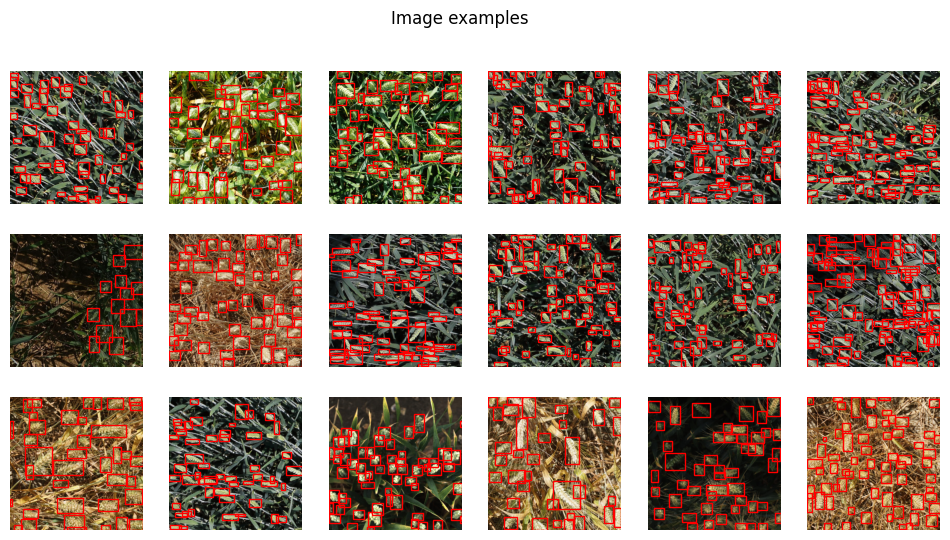

In [5]:
plot_image_examples(all_train_images)

### Creating a Custom Dataset

For convenient data loading, here we define a regular PyTorch dataset. The __init__ function is run once when instantiating the Dataset object. The __len__ function returns the number of samples in our dataset. The __getitem__ function loads and returns a sample from the dataset at the given index idx.

We add a feature extractor (`DetrFeatureExtractor`) to resize + normalize the images, and to turn the annotations (which are in COCO format) in the format that DETR expects. It will also resize the annotations accordingly.

Check out [this](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) PyTorch tutorial for a better understanding of Datasets and Dataloaders.

In [6]:
# ----------
#  Dataset Retriever
# ----------

class DatasetRetriever(torch.utils.data.Dataset):
    def __init__(self, dataframe, feature_extractor):
        super(DatasetRetriever, self).__init__()
        self.dataframe = dataframe.reset_index(drop=True)
        self.image_ids = self.dataframe['image_id'].unique().tolist()
        self.image_names = self.dataframe['image_name'].unique().tolist()
        self.feature_extractor = feature_extractor
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        # Select image_id and its corresponding records
        image_id = self.image_ids[idx] 
        image_name = self.image_names[image_id]
        records = self.dataframe[self.dataframe['image_id'] == image_id]
        
        # Load image
        image_path = str(Path(TRAIN_DIR + f'{image_name}.jpg')) 
        image = Image.open(image_path).convert('RGB')
        
        # Select bbox annotations
        annotations = records[['bbox_xmin', 'bbox_ymin', 'bbox_width', 'bbox_height']].values
        
        # Create annotation format as per required by feature extractor
        annotations = [
            {"bbox": annotation.astype(int).tolist(), "category_id":LABEL2ID[label], 'area':area} \
                for annotation, label, area in zip(annotations, records['label'], records['area'])
        ]
        
        # Perform encoding
        target = {'image_id': image_id, 'annotations': annotations}
        encoding = self.feature_extractor(images=image, annotations=target, return_tensors="pt")
        
        # Return pixel values and target
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0]
        return pixel_values, target

Based on the class defined above, we create training and validation datasets. We then print the total number of images in training and validation dataset.

In [7]:
# ----------
#  Dataset
# ----------

train_df = all_train_images.copy()

# Train test split
image_ids = train_df['image_name'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

# Create train and validation dataframes
valid_df = train_df[train_df['image_name'].isin(valid_ids)]
train_df = train_df[train_df['image_name'].isin(train_ids)]

# Create image2id mapping dict
train_img2id = dict(zip(train_df.image_name.unique(), range(len(train_df.image_name.unique())))) 
valid_img2id = dict(zip(valid_df.image_name.unique(), range(len(valid_df.image_name.unique()))))

# Create image_id column
train_df['image_id'] = train_df['image_name'].map(train_img2id)
valid_df['image_id'] = valid_df['image_name'].map(valid_img2id)

# Initialize feature extractor and datasets
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
train_dataset = DatasetRetriever(dataframe=train_df, feature_extractor=feature_extractor)
val_dataset = DatasetRetriever(dataframe=valid_df, feature_extractor=feature_extractor)

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 2757
Number of validation examples: 665


The next step is to create corresponding dataloaders. To batch images together, we define a custom `collate_fn`. DETR resizes images so that they have a minimum size of 800 and a maximum size of 1333. 

In a batch, we pad images (`pixel_values`) to the largest image in the batch and create `pixel_mask` to indicate which pixels are real (1)/padding (2).

In [9]:
# ----------
#  Dataloader
# ----------

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['pixel_mask'] = encoding['pixel_mask']
    batch['labels'] = labels
    return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=VAL_BATCH_SIZE)
batch = next(iter(train_dataloader))

Let's verify the keys of a single batch:

In [10]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

Let's verify the shape of the pixel_values, and check the target:

In [11]:
pixel_values, target = train_dataset[0]
print(pixel_values.shape)
print(target)

torch.Size([3, 512, 512])
{'boxes': tensor([[0.0181, 0.6929, 0.0361, 0.1084],
        [0.0659, 0.8457, 0.1318, 0.0957],
        [0.0107, 0.2271, 0.0215, 0.0791],
        [0.0347, 0.3525, 0.0615, 0.0371],
        [0.1201, 0.3657, 0.0801, 0.0791],
        [0.0527, 0.3130, 0.0469, 0.0479],
        [0.2061, 0.3350, 0.0684, 0.0527],
        [0.2056, 0.1479, 0.0674, 0.0498],
        [0.2188, 0.0786, 0.0410, 0.0830],
        [0.0464, 0.1670, 0.0869, 0.0566],
        [0.2598, 0.0122, 0.0586, 0.0244],
        [0.3579, 0.0278, 0.0732, 0.0557],
        [0.8110, 0.0469, 0.0674, 0.0938],
        [0.6724, 0.0674, 0.0576, 0.0879],
        [0.5957, 0.1182, 0.1367, 0.0781],
        [0.2710, 0.1733, 0.0869, 0.0498],
        [0.4404, 0.1797, 0.0566, 0.0488],
        [0.5513, 0.1807, 0.2002, 0.0625],
        [0.5098, 0.2310, 0.1055, 0.0518],
        [0.4736, 0.2725, 0.1328, 0.0859],
        [0.3076, 0.2759, 0.0547, 0.0498],
        [0.3335, 0.3516, 0.1143, 0.0742],
        [0.4688, 0.3701, 0.1699, 0.0977]

### Initialize Model, Optimizer, Scheduler and Mixed Precision Training 

- To initialize the model, we use the `facebook/detr-resnet-50`. 


- Our optimizer will be `AdamW` with differential learning for the backbone and head. 


- The scheduler we use is `cosine schedule with warmup`. Often, we want to warm up the model with a slowly increasing learning rate and then cool it down with a decreasing learning rate. With warmup cosine decay, the learning rate linearly increases for the warmup steps and then decays.


- Finally, we initialize cuda `mixed precision` for speeding up the training process.

In [12]:
# ----------
#  Model
# ----------

model = AutoModelForObjectDetection.from_pretrained(
    MODEL_NAME_OR_PATH, 
    num_labels=len(LABEL2ID), 
    ignore_mismatched_sizes=True
).to(DEVICE)

# ----------
#  Optimizer
# ----------

grouped_optimizer_parameters = param_dicts = [
      {"params": [p for n, p in model.named_parameters() if "backbone" not in n and p.requires_grad]},
      {"params": [p for n, p in model.named_parameters() if "backbone" in n and p.requires_grad], "lr": LR_BACKBONE},
]

optimizer = torch.optim.AdamW(grouped_optimizer_parameters, lr=LR, weight_decay=WEIGHT_DECAY)

# ----------
#  Scheduler
# ----------

num_training_steps = len(train_dataloader) * N_EPOCHS
num_warmup_steps = math.ceil(num_training_steps * WARMUP_RATIO)
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, 
    num_training_steps=num_training_steps
)

# ----------
#  Mixed Precision Training
# ----------

scaler = torch.cuda.amp.GradScaler()
autocast = torch.cuda.amp.autocast(enabled=True, dtype=torch.float16)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Model Information

Below, we print general information about the model - its parameters, gradients, etc.

In [13]:
# ----------
#  Model Information
# ----------

def model_info(model):
    # Parameters and gradients
    n_p = sum(x.numel() for x in model.parameters())
    n_g = sum(x.numel() for x in model.parameters() if x.requires_grad)
    
    # Model size
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size = (param_size + buffer_size) / 1024**2
    
    # Model name
    name = type(model).__name__
    print(f" {name} summary: {len(list(model.modules()))} layers, {n_p} parameters, {n_g} gradients, size {size:.1f} MB")
    
model_info(model)

 DetrForObjectDetection summary: 388 layers, 41509318 parameters, 41286406 gradients, size 158.7 MB


To keep track of our losses during training, we define a utility class.

In [14]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

### Train the model using PyTorch

In [15]:
# ----------
#  Run
# ----------

loss_hist = Averager()
for epoch in range(N_EPOCHS):
    
    # ----------
    #  Training
    # ----------
    
    model.zero_grad()
    loss_hist.reset()
    pbar = tqdm(train_dataloader, position=0, total=len(train_dataloader), desc="Training ")
    
    for i, batch in enumerate(pbar):
        # Enable model training
        model.train()
        
        # Move inputs to device
        pixel_values = batch['pixel_values'].to(DEVICE)
        pixel_mask = batch['pixel_mask'].to(DEVICE)
        labels = [{k:v.to(DEVICE) for k, v in t.items()} for t in batch['labels']]
        
        # Forward pass
        with torch.set_grad_enabled(True):
            with autocast:
                outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)
        
        # Fetch loss
        loss_dict = outputs.loss_dict
        losses = sum(loss for loss in list(loss_dict.values())[:-1])
        loss_value = losses.item()
        loss_hist.send(loss_value)
        
        # Log
        pbar.set_description(
            "[Training] [Epoch %d/%d] [Batch %d/%d] [loss: %.4f]"
            % (epoch + 1, N_EPOCHS, i, len(train_dataloader), loss_hist.value)
        )
        
        # Backpropagation
        scaler.scale(losses).backward()
        
        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRADIENT_CLIP_VAL)
        
        # Gradient update
        scale_before = scaler.get_scale()
        scaler.step(optimizer)
        scaler.update()
        scaler_after = scaler.get_scale()
        optimizer_was_run = scale_before <= scaler_after
        
        if optimizer_was_run:
            scheduler.step()
        
        # zero out gradients
        model.zero_grad()
    
    # ----------
    #  Validation
    # ----------
    
    loss_hist.reset()
    pbar = tqdm(val_dataloader, position=0, total=len(val_dataloader), desc="Validation ")
    for i, batch in enumerate(pbar):
        # Enable model evaluation
        model.eval()
        
        # Move inputs to device
        pixel_values = batch['pixel_values'].to(DEVICE)
        pixel_mask = batch['pixel_mask'].to(DEVICE)
        labels = [{k:v.to(DEVICE) for k, v in t.items()} for t in batch['labels']]
        
        # Forward pass
        with torch.set_grad_enabled(False):
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)
                
        # Fetch loss
        loss_dict = outputs.loss_dict
        losses = sum(loss for loss in list(loss_dict.values())[:-1])
        loss_value = losses.item()
        loss_hist.send(loss_value)
        
        # Log
        pbar.set_description(
            "[Validation] [Epoch %d/%d] [loss: %.4f]"
            % (epoch + 1, N_EPOCHS, loss_hist.value)
        )
    
    torch.cuda.empty_cache()

Training :   0%|          | 0/345 [00:00<?, ?it/s]

Validation :   0%|          | 0/167 [00:00<?, ?it/s]

Training :   0%|          | 0/345 [00:00<?, ?it/s]

Validation :   0%|          | 0/167 [00:00<?, ?it/s]

Training :   0%|          | 0/345 [00:00<?, ?it/s]

Validation :   0%|          | 0/167 [00:00<?, ?it/s]

Training :   0%|          | 0/345 [00:00<?, ?it/s]

Validation :   0%|          | 0/167 [00:00<?, ?it/s]

### Inference + Visualizing Predictions

Let's visualize the predictions of DETR on the first image of the validation set.

In [19]:
# ----------
#  Inference and Visualization     
# ----------

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    # calculate linewidth
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{ID2LABEL[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show() 

In [20]:
def visualize_predictions(image, outputs, threshold=0.95):
    # keep only predictions with confidence >= threshold
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    # convert predicted boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

    # plot results
    plot_results(image, probas[keep], bboxes_scaled)

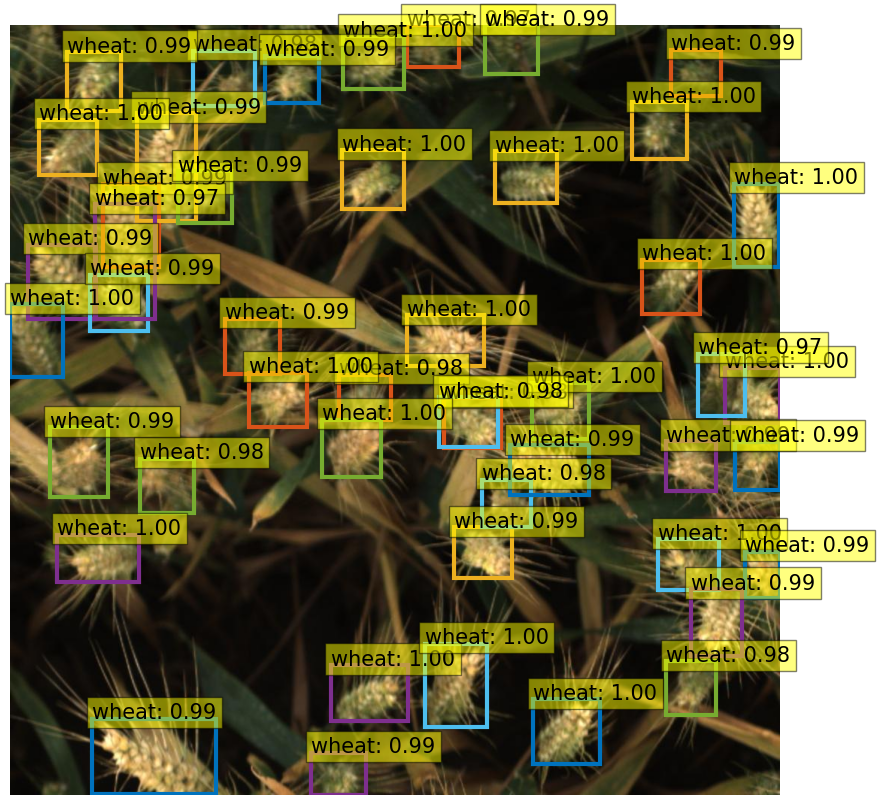

In [21]:
INDEX = 0
pixel_values, target = val_dataset[INDEX]
pixel_values = pixel_values.unsqueeze(0).to(DEVICE)
outputs = model(pixel_values=pixel_values, pixel_mask=None)

# load image
image_id = target['image_id'].item()
image_name = val_dataset.image_names[image_id]
image = Image.open(os.path.join('data/train/', image_name + '.jpg'))

# Visualize predictions
image = visualize_predictions(image, outputs)

### Closing thoughts

In this blogpost, we examined in great detail the architecture and capabilities of the DEtection TRansformer framework. We then demonstrated how to use this model with PyTorch to detect wheat heads.

The DETR is a new design for object detection systems that uses transformers and bipartite matching loss for direct set prediction. Compared to an optimized Faster R-CNN baseline on the challenging COCO dataset, this approach achieves comparable results. Implementation of DETR is straightforward and has a flexible architecture that can be easily extended to panoptic segmentation. 

Due to self-attention, it performs significantly better on large objects than Faster R-CNN. Training, optimization, and small object performance are new challenges with this new design.

We encourage you to try different datasets for object detection!

Acknowledgements: 

- [DETR](https://huggingface.co/docs/transformers/model_doc/detr) model documentation from HuggingFace.
- [Fine-tuning DETR on a custom dataset for object detection](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb) notebook by Niels Rogge.
- [Pytorch Starter - FasterRCNN Train](https://www.kaggle.com/code/pestipeti/pytorch-starter-fasterrcnn-train) notebook by Peter.
- [GlobalWheatDetection EDA](https://www.kaggle.com/code/aleksandradeis/globalwheatdetection-eda) notebook by Alexsandra Deis.


